In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image,ImageOps
import os
import math
import json
from io import StringIO
import skimage as ski
from skimage import data, io, filters
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

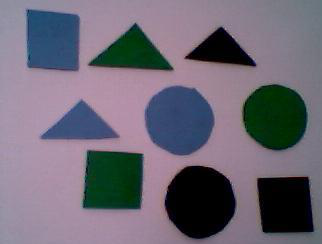

In [2]:
photo = os.path.join("foto.jpg")
ph = Image.open(photo)
ph

### Funciones de Extracción de Características

In [3]:
def binarize_image(img, threshold=160):
    """
        Función para binarizar una imagen en blanco y negro
        threshold: valor entero el cual usa para diferenciar entre negro y blanco
        un valor más bajo o igual que threshold es negro en cualquier otro caso es blanco
    """
    x, y = img.shape
    z = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            value = int(img[i,j] * 255)
            if value <= threshold:
                z[i, j] = 0
            else:
                z[i, j] = 255
    return z

def extract_characteristics(img):
    """
        Función que preprocesa la imagen y retorna los centroides y los momentos de Hu
    """
    # Convertimos en un arreglo la imagen
    array = np.array(img)
    # Cambiamos la codificación de colores a escala de grises
    grayscale_ph = ski.color.rgb2gray(array)
    # Invertimos el colore de los pixeles
    inverted_ph = ski.util.invert(grayscale_ph)
    # Binarizamos la imagen en blanco y negro
    bin_image = binarize_image(inverted_ph)
    # Creamos los labels para las regiones
    label_image = ski.measure.label(bin_image)
    # Mostramos las regiones
    plt.imshow(ski.color.label2rgb(label_image))
    regions = ski.measure.regionprops(label_image)
    # Obtenemos los centroides y los momentos de Hu
    centroids = []
    hu_moments = []
    for region in regions:
        centroids.append(region.centroid)
        hu_moments.append(region.moments_hu)
    return centroids, hu_moments
        

/home/reus/anaconda3/envs/ANN/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/reus/anaconda3/envs/ANN/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


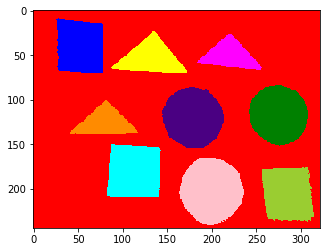

In [4]:
color_characteristics, form_characteristics = extract_characteristics(ph)

### Clasificador de Color
- Azul=[1, 0, 0]
- Verde/Café=[0, 1, 0]
- Negro=[0, 0, 1]

In [5]:
def obtain_pixel(arr, coordinate):   
    x = int(coordinate[0])
    y = int(coordinate[1])
    return np.array([arr[x, y][0], arr[x, y][1], arr[x, y][2]]), "RGB({0}, {1}, {2})".format(
        arr[x, y][0], arr[x, y][1], arr[x, y][2])
    

def color_reader(image, characteristics, filename):
    arr = np.array(image)
    with open(filename) as data_file:    
         tags = json.load(data_file)
    train_data = []
    train_tags = []
    for char in characteristics:
        data, tag = obtain_pixel(arr, char)
        train_data.append(data)
        train_tags.append(tags[tag]) 
    return np.array(train_data), np.array(train_tags)


In [6]:
json_filepath = os.path.join("tarea_color.json")
X_train, y_train = color_reader(ph, color_characteristics, json_filepath)
print(X_train)
print(y_train)

[[ 43  77 114]
 [  1  60  16]
 [  1   1   0]
 [  0  40   4]
 [ 51  70 110]
 [ 62  81 123]
 [  0  56  17]
 [  0   0   0]
 [  0   0   0]]
[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]]


In [7]:
color_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5,
                  hidden_layer_sizes=(10, 3), random_state=1)

In [8]:
color_classifier.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [9]:
def one_hot_detector(onehot):
    return [np.argmax(output) for output in onehot]
pred = color_classifier.predict(X_train)
predclass=one_hot_detector(pred)
yclass=one_hot_detector(y_train)
print(accuracy_score(predclass,yclass)) 
print(confusion_matrix(predclass,yclass))

1.0
[[3 0 0]
 [0 3 0]
 [0 0 3]]


### Clasificador de forma
- Cuadro = [1, 0, 0]
- Triángulo = [0, 1, 0]
- Círculo = [0, 0, 1]

In [10]:
def form_reader(characteristics, filename):
    with open(filename) as data_file:    
         tags = json.load(data_file)
    train_data = []
    train_tags = []
    for i, char in enumerate(characteristics):
        train_data.append(char)
        train_tags.append(tags[str(i + 1)]) 
    return np.array(train_data), np.array(train_tags)

In [11]:
json_filepath = os.path.join("tarea_forma.json")
X_train, y_train = form_reader(form_characteristics, json_filepath)

In [12]:
form_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5,
                  hidden_layer_sizes=(10, 3), random_state=1)

In [13]:
form_classifier.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [14]:
pred = form_classifier.predict(X_train)
predclass = one_hot_detector(pred)
yclass = one_hot_detector(y_train)
print(accuracy_score(predclass,yclass)) 
print(confusion_matrix(predclass,yclass))

1.0
[[3 0 0]
 [0 3 0]
 [0 0 3]]
